# Capstone Project - The Battle of the Neighborhoods (Week 1)

## Table of contents
* [Introduction: Problem Description](#introduction)
* [Data Description](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


### Introduction: Problem Description
<a id="introduction"></a>

Two of the most important cities in the world are New York City and City of Toronto. Every year millions of tourists visit these cities for business and pleasure. 

The main reasons for tourist to visit these cities are as follows:

* Discover different neighborhoods
* Stand in the awe of skyscrapers
* Enjoying different international and experimental foods
* Visiting world renowned arts and galleries

People from different part of the world come to visit, they like to explore places, taste similar and different cuisines, enjoy popular sites and much more. When someone wants to visit and has to decide which city to choose, the visitor/visitors would like to compare two cities based on their likes and dislikes.

A comparison of the venues between two cities will help people decide where to visit. A data analysis between New York city and Toronto which gives a picture of the sought after venues will serve the purpose.

### Data Description
<a id="data"></a>

In order to make a comparative analysis of venues of interest between two cities( New York and Toronto), we need effective datasets for both the two cities. 

Following data sources will be needed to extract/generate the required information:

* New York City data will be obtained from a json file obtained from IBM Developer Skills Network
* City of Toronto postal codes are obtained from a Wikipedia page
* City of Toronto data will be obtained from a csv file that has the geographical coordinates of each postal code: http://cocl.us/Geospatial_dataFollowing 
* Number of restaurants and their type and location in every neighborhood will be obtained using Foursquare API

Communicating with the Foursquare database is done by their RESTful API. A uniform resource identifier or URI is created and  extra parameters are appended depending on the data that we are seeking from the database. Any call request you make is composed of, we can call this base URI, which is api.foursquare.com/v2, and you can request data about venues, users, or tips.

For New York City, We will be using the coordinates of Manhattan to conduct the search.
For City of Toronto, the coordinates of Toronto city will be used.



In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes  
#uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


#### City of Toronto Data Preparation

A dataframe will be created from a Wikipedia page. The dataframe will consist of three columns:PostalCode, Borough, and Neighborhood.

In [2]:
url='https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=1011037969'

In [3]:
df = pd.read_html(url)[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [4]:
filt = (df['Borough'] !='Not assigned')
df=df[filt]
df.rename(columns={'Postal Code':'PostalCode'}, inplace =True)
df.head()

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [5]:
df.reset_index(drop=True, inplace=True)
df.head()

,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [6]:
df_postal = df.groupby(['PostalCode','Borough'])['Neighbourhood'].apply(','.join).reset_index()
df_postal.set_index('PostalCode', inplace = True)
df_postal.head()

,Borough,Neighbourhood
PostalCode,,
M1B,Scarborough,"Malvern, Rouge"
M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
M1E,Scarborough,"Guildwood, Morningside, West Hill"
M1G,Scarborough,Woburn
M1H,Scarborough,Cedarbrae


Create a dataframe with latitude and longitude from the csv file that has the geographical coordinates of each postal code

In [7]:
df_latlong = pd.read_csv('Geospatial_Coordinates.csv')
df_latlong.rename(columns={'Postal Code':'PostalCode'}, inplace=True)
df_latlong.set_index('PostalCode', inplace = True)
df_latlong.head()

,Latitude,Longitude
PostalCode,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


Join two dataframes to create one dataframe with PostalCode, Borough, Neighborhood, Latitude and Longitude

In [8]:
toronto_data = df_postal.join(df_latlong)
toronto_data.reset_index(inplace=True)
toronto_data.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_data['Borough'].unique()),
        toronto_data.shape[0]
    )
)

The dataframe has 11 boroughs and 103 neighborhoods.


##### Let's get the geographical coordinates of Toronto

In [10]:
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [11]:
CLIENT_ID = 'YP0SOLEF10ANMVNHTI2UUHNKJEA3Q52YJJXS0AGPPHJ4C15Q' # Foursquare ID
CLIENT_SECRET = 'ARHXH0TAGBK5DOBTZ5DJ0SHOGKBBLBAW5MHTLWPOXM4B3QFT' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YP0SOLEF10ANMVNHTI2UUHNKJEA3Q52YJJXS0AGPPHJ4C15Q
CLIENT_SECRET:ARHXH0TAGBK5DOBTZ5DJ0SHOGKBBLBAW5MHTLWPOXM4B3QFT


### 2. Explore Neighbourhoods in Toronto

Let's create a function to get the venues to all the neighborhoods in Toronto

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### The following code to run the above function on each neighborhood and create a new dataframe called toronto_venues.

In [13]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

##### Let's check the size of the resulting dataframe

In [14]:
print(toronto_venues.shape)
toronto_venues.head()

(2136, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Great Shine Window Cleaning,43.783145,-79.157431,Home Service
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [15]:
len(toronto_venues['Venue'].unique())

1392

In [16]:
len(toronto_venues['Venue Category'].unique())

274

In [17]:
print('Total number of venues in Toronto :{}'.format(toronto_venues.shape[0]))
print('Total number of unique venues in Toronto:{}'.format(len(toronto_venues['Venue'].unique())))
print('Total number of venue categories in Toronto :{}'.format(len(toronto_venues['Venue Category'].unique())))

Total number of venues in Toronto :2136
Total number of unique venues in Toronto:1392
Total number of venue categories in Toronto :274


#### Let's create a dataframe with Toronto venues

In [18]:
toronto_df = pd.DataFrame({'No. of Venue':[toronto_venues.shape[0]],
                          'No. of Unique Venue':[len(toronto_venues['Venue'].unique())],
                          'No. of Unique Venue Category':[len(toronto_venues['Venue Category'].unique())]})
toronto_df = toronto_df.T
toronto_df.columns =['Toronto']
toronto_df

,Toronto
No. of Venue,2136
No. of Unique Venue,1392
No. of Unique Venue Category,274


In [19]:
toronto_df.reset_index(inplace=True)

In [20]:
toronto_df.columns = ['Items', 'Toronto']
toronto_df

,Items,Toronto
0,No. of Venue,2136
1,No. of Unique Venue,1392
2,No. of Unique Venue Category,274


##### Let's get the frequency of all the venue categories that is the total number of each venue categories in toronto

In [21]:
toronto_venue_cat = toronto_venues.groupby('Venue Category').count()['Neighbourhood'].to_frame()['Neighbourhood'].sort_values(ascending=False).to_frame()

In [22]:
toronto_venue_cat.reset_index(inplace = True)

In [23]:
toronto_venue_cat.head()

,Venue Category,Neighbourhood
0,Coffee Shop,186
1,Café,92
2,Restaurant,62
3,Park,55
4,Bakery,49


In [24]:
toronto_venue_cat = toronto_venue_cat.rename(columns={'Venue Category':'Venue Category', 'Neighbourhood':'Toronto'})
toronto_venue_cat

,Venue Category,Toronto
0,Coffee Shop,186
1,Café,92
2,Restaurant,62
3,Park,55
4,Bakery,49
5,Italian Restaurant,47
6,Pizza Place,47
7,Japanese Restaurant,42
8,Sandwich Place,40
9,Hotel,34


In [25]:
toronto_venue_cat.shape

(274, 2)

##### Let's get number of all the restaurants in Toronto

In [26]:
filt_1 = toronto_venue_cat['Venue Category'].str.contains('Restaurant')
toronto_restaurants = toronto_venue_cat[filt_1]
#toronto_restaurants = toronto_restaurants.rename(columns = {'Venue Category':'Venue Category', 'Neighbourhood':'No. of Restaurant'})
toronto_restaurants.set_index('Venue Category', inplace=True)
#toronto_restaurants.reset_index(inplace= True)

In [27]:
toronto_restaurants

,Toronto
Venue Category,
Restaurant,62
Italian Restaurant,47
Japanese Restaurant,42
Sushi Restaurant,30
Fast Food Restaurant,29
Seafood Restaurant,24
Thai Restaurant,22
American Restaurant,19
Vegetarian / Vegan Restaurant,16


In [28]:
Number_of_Toronto_restaurants = 0

for n in range(toronto_restaurants.shape[0]):
    Number_of_Toronto_restaurants = Number_of_Toronto_restaurants + int(toronto_restaurants['Toronto'][n])
    
print('Total number of restaurants in Toronto is :', Number_of_Toronto_restaurants)

Total number of restaurants in Toronto is : 481


In [29]:
#toronto_restaurants.to_excel('toronto_restaurant.xlsx')

##### Let's check how many venues were returned for each neighborhood

In [30]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",6,6,6,6,6,6
"Bathurst Manor, Wilson Heights, Downsview North",23,23,23,23,23,23
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
Berczy Park,58,58,58,58,58,58
"Birch Cliff, Cliffside West",5,5,5,5,5,5
"Brockton, Parkdale Village, Exhibition Place",24,24,24,24,24,24
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",19,19,19,19,19,19


##### Let's find out how many unique categories can be curated from all the returned venues

In [31]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 274 uniques categories.


### 3. Analyze Each Neighborhood

In [32]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

##### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [33]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

##### Confirm the new size

In [34]:
toronto_grouped.shape

(94, 275)

##### Let's print each neighborhood along with the top 5 most common venues

In [35]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0  Latin American Restaurant  0.25
1             Breakfast Spot  0.25
2                     Lounge  0.25
3               Skating Rink  0.25
4  Middle Eastern Restaurant  0.00


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.33
1  Sandwich Place  0.17
2             Gym  0.17
3     Coffee Shop  0.17
4             Pub  0.17


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0                       Bank  0.09
1                Coffee Shop  0.09
2                      Diner  0.04
3              Shopping Mall  0.04
4  Middle Eastern Restaurant  0.04


----Bayview Village----
                 venue  freq
0  Japanese Restaurant  0.25
1   Chinese Restaurant  0.25
2                 Bank  0.25
3                 Café  0.25
4        Metro Station  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0  Italian Restaurant  0.08
1      Sandwich Place  0.08

               venue  freq
0     Discount Store  0.29
1         Hobby Shop  0.14
2  Convenience Store  0.14
3        Coffee Shop  0.14
4   Department Store  0.14


----Kensington Market, Chinatown, Grange Park----
                           venue  freq
0                            Bar  0.07
1                           Café  0.07
2  Vegetarian / Vegan Restaurant  0.04
3          Vietnamese Restaurant  0.04
4                    Coffee Shop  0.04


----Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens----
               venue  freq
0     Sandwich Place  0.25
1               Park  0.25
2           Bus Line  0.25
3  Mobile Phone Shop  0.25
4  Accessories Store  0.00


----Lawrence Manor, Lawrence Heights----
                 venue  freq
0       Clothing Store  0.33
1    Accessories Store  0.17
2          Coffee Shop  0.08
3  Sporting Goods Shop  0.08
4          Event Space  0.08


----Lawrence Park----
                venue  freq
0                Park  0.33
1         S

##### Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Skating Rink,Latin American Restaurant,Breakfast Spot,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,"Alderwood, Long Branch",Pizza Place,Gym,Coffee Shop,Sandwich Place,Pub,Yoga Studio,Dog Run,Dim Sum Restaurant,Diner,Discount Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Frozen Yogurt Shop,Bridal Shop,Sandwich Place,Diner,Restaurant,Middle Eastern Restaurant,Intersection,Deli / Bodega
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Diner,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Pet Store,Restaurant,Butcher,Café,Pub,Pizza Place,Pharmacy


In [38]:
neighbourhoods_venues_sorted.shape

(94, 11)

In [39]:
len(neighbourhoods_venues_sorted['1st Most Common Venue'].unique())

43

### 4. Cluster Neighbourhoods

We analyze the clusters of city of Toronto and Manhattan by the number of the most common venues  for each cluster.

In [40]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

##### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood of Toronto.

In [41]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood', how = 'right')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,M1S,Scarborough,Agincourt,43.794200,-79.262029,0,Lounge,Skating Rink,Latin American Restaurant,Breakfast Spot,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
89,M8W,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484,0,Pizza Place,Gym,Coffee Shop,Sandwich Place,Pub,Yoga Studio,Dog Run,Dim Sum Restaurant,Diner,Discount Store
28,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,0,Coffee Shop,Bank,Frozen Yogurt Shop,Bridal Shop,Sandwich Place,Diner,Restaurant,Middle Eastern Restaurant,Intersection,Deli / Bodega
19,M2K,North York,Bayview Village,43.786947,-79.385975,0,Café,Japanese Restaurant,Bank,Chinese Restaurant,Diner,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
62,M5M,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,0,Coffee Shop,Sandwich Place,Italian Restaurant,Pet Store,Restaurant,Butcher,Café,Pub,Pizza Place,Pharmacy


##### Finally, let's visualize the resulting clusters

In [42]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [43]:
Toronto_Cluster_1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
Toronto_Cluster_1

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Scarborough,0,Lounge,Skating Rink,Latin American Restaurant,Breakfast Spot,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
89,Etobicoke,0,Pizza Place,Gym,Coffee Shop,Sandwich Place,Pub,Yoga Studio,Dog Run,Dim Sum Restaurant,Diner,Discount Store
28,North York,0,Coffee Shop,Bank,Frozen Yogurt Shop,Bridal Shop,Sandwich Place,Diner,Restaurant,Middle Eastern Restaurant,Intersection,Deli / Bodega
19,North York,0,Café,Japanese Restaurant,Bank,Chinese Restaurant,Diner,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
62,North York,0,Coffee Shop,Sandwich Place,Italian Restaurant,Pet Store,Restaurant,Butcher,Café,Pub,Pizza Place,Pharmacy
56,Downtown Toronto,0,Cocktail Bar,Bakery,Coffee Shop,Pharmacy,Cheese Shop,Pub,Restaurant,Farmers Market,Beer Bar,Seafood Restaurant
9,Scarborough,0,Farm,College Stadium,Café,Skating Rink,General Entertainment,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant
78,West Toronto,0,Café,Breakfast Spot,Coffee Shop,Yoga Studio,Pet Store,Stadium,Burrito Place,Restaurant,Climbing Gym,Gym
87,East Toronto,0,Light Rail Station,Yoga Studio,Pizza Place,Smoke Shop,Skate Park,Brewery,Burrito Place,Restaurant,Recording Studio,Park
68,Downtown Toronto,0,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Bar,Coffee Shop,Plane,Rental Car Location,Sculpture Garden,Boat or Ferry


In [44]:
Toronto_Cluster_2 =toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
Toronto_Cluster_2

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
74,York,1,Park,Women's Store,Pool,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
40,East York,1,Intersection,Metro Station,Park,Pizza Place,Convenience Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
64,Central Toronto,1,Park,Trail,Sushi Restaurant,Jewelry Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dim Sum Restaurant
72,North York,1,Park,Bakery,Asian Restaurant,Japanese Restaurant,Yoga Studio,Drugstore,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
7,Scarborough,1,Bus Line,Bakery,Soccer Field,Ice Cream Shop,Intersection,Park,Golf Course,Falafel Restaurant,Ethiopian Restaurant,Escape Room
73,York,1,Park,Trail,Field,Hockey Arena,Yoga Studio,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
100,Etobicoke,1,Park,Mobile Phone Shop,Bus Line,Sandwich Place,Yoga Studio,Doner Restaurant,Discount Store,Distribution Center,Dog Run,Donut Shop
44,Central Toronto,1,Park,Swim School,Bus Line,Yoga Studio,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
14,Scarborough,1,Park,Playground,Intersection,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
79,North York,1,Park,Basketball Court,Bakery,Construction & Landscaping,Trail,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore


In [45]:
Toronto_Cluster_3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
Toronto_Cluster_3

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,2,Fast Food Restaurant,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,College Stadium


In [46]:
Toronto_Cluster_4=toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
Toronto_Cluster_4

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
97,North York,3,Baseball Field,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Diner
91,Etobicoke,3,Baseball Field,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Diner


In [47]:
Toronto_Cluster_5=toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
Toronto_Cluster_5

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
94,Etobicoke,4,Bakery,Middle Eastern Restaurant,Yoga Studio,Drugstore,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Diner
11,Scarborough,4,Smoke Shop,Bakery,Middle Eastern Restaurant,Sandwich Place,Yoga Studio,Donut Shop,Distribution Center,Dog Run,Doner Restaurant,Drugstore


In [48]:
type(Toronto_Cluster_5['1st Most Common Venue'].value_counts())

pandas.core.series.Series

### New York City data preparation
Data is extracted from the following url named as newyorkurl.

In [49]:
import urllib.request

In [50]:
newyorkurl = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json'

In [51]:
response = urllib.request.urlopen(newyorkurl)
content = response.read()
newyork_data = json.loads(content.decode("utf8"))
print(newyork_data)


{'type': 'FeatureCollection', 'totalFeatures': 306, 'features': [{'type': 'Feature', 'id': 'nyu_2451_34572.1', 'geometry': {'type': 'Point', 'coordinates': [-73.84720052054902, 40.89470517661]}, 'geometry_name': 'geom', 'properties': {'name': 'Wakefield', 'stacked': 1, 'annoline1': 'Wakefield', 'annoline2': None, 'annoline3': None, 'annoangle': 0.0, 'borough': 'Bronx', 'bbox': [-73.84720052054902, 40.89470517661, -73.84720052054902, 40.89470517661]}}, {'type': 'Feature', 'id': 'nyu_2451_34572.2', 'geometry': {'type': 'Point', 'coordinates': [-73.82993910812398, 40.87429419303012]}, 'geometry_name': 'geom', 'properties': {'name': 'Co-op City', 'stacked': 2, 'annoline1': 'Co-op', 'annoline2': 'City', 'annoline3': None, 'annoangle': 0.0, 'borough': 'Bronx', 'bbox': [-73.82993910812398, 40.87429419303012, -73.82993910812398, 40.87429419303012]}}, {'type': 'Feature', 'id': 'nyu_2451_34572.3', 'geometry': {'type': 'Point', 'coordinates': [-73.82780644716412, 40.887555677350775]}, 'geometry_n

Notice how all the relevant data is in the _features_ key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [52]:
neighborhoods_data = newyork_data['features']

Let's look at the first item in this list.

In [53]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

##### Tranform the data into a pandas dataframe

In [54]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [55]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [56]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [57]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [58]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


##### let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [59]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent ny_explorer, as shown below.

In [60]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7896239, -73.9598939.


In [61]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

### 2. Explore Neighborhoods in Manhattan

Let's create a function to for all the neighborhoods in Manhattan

In [62]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

##### Now write the code to run the above function on each neighborhood and create a new dataframe called _manhattan_venues_.

In [63]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


**Let's get the number of unique venues in Manhattan**

In [64]:
print('The total number of venues in manhattan is {}'.format(manhattan_venues.shape[0]))
manhattan_venues.head()

The total number of venues in manhattan is 3252


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
3,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


In [65]:
print('The number of unique venues in manhattan is {}'.format(len(manhattan_venues['Venue'].unique())))

The number of unique venues in manhattan is 2765


**Let's get the number of unique venue catagories in Manhattan**

In [66]:
print('The number of unique venue catagories in manhattan is {}'.format(len(manhattan_venues['Venue Category'].unique())))

The number of unique venue catagories in manhattan is 334


In [67]:
manhattan_venues.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Accessories Store,3,3,3,3,3,3
Adult Boutique,2,2,2,2,2,2
Afghan Restaurant,1,1,1,1,1,1
African Restaurant,3,3,3,3,3,3
American Restaurant,79,79,79,79,79,79
Antique Shop,1,1,1,1,1,1
Arepa Restaurant,1,1,1,1,1,1
Argentinian Restaurant,5,5,5,5,5,5
Art Gallery,24,24,24,24,24,24


**Let's create a dataframe with no. of venues, no. of unique venues and number of unique venue categories for Manhattan called manhattan_df**

In [68]:
manhattan_df = pd.DataFrame({'No. of Venue':[manhattan_venues.shape[0]],
                          'No. of Unique Venue':[len(manhattan_venues['Venue'].unique())],
                          'No. of Unique Venue Category':[len(manhattan_venues['Venue Category'].unique())]})
manhattan_df = manhattan_df.T
manhattan_df.columns =['Manhattan']
manhattan_df

,Manhattan
No. of Venue,3252
No. of Unique Venue,2765
No. of Unique Venue Category,334


In [69]:
manhattan_df.reset_index(inplace = True)

In [70]:
manhattan_df.columns = ['Items', 'Manhattan']
manhattan_df

,Items,Manhattan
0,No. of Venue,3252
1,No. of Unique Venue,2765
2,No. of Unique Venue Category,334


##### Let's get the frequency of all the venue categories that is the total number of each venue categories in manhattan in descending order. This will give the most popular ones on the top and so on.
Let's name the dataframe as manhattan_venue_cat

In [71]:
manhattan_venue_cat = manhattan_venues.groupby('Venue Category').count()['Neighborhood'].to_frame()['Neighborhood'].sort_values(ascending=False).to_frame()

In [72]:
manhattan_venue_cat.reset_index(inplace = True)

In [73]:
manhattan_venue_cat.rename(columns={'Venue Category':'Venue Category', 'Neighborhood':'Manhattan'}, inplace=True)
manhattan_venue_cat

,Venue Category,Manhattan
0,Coffee Shop,138
1,Italian Restaurant,131
2,American Restaurant,79
3,Café,79
4,Bakery,77
5,Pizza Place,75
6,Park,70
7,Hotel,66
8,Bar,62
9,Cocktail Bar,58


In [74]:
manhattan_venue_cat.to_excel('manhattan_venue_cat.xlsx')

In [75]:
print('There are {} uniques venue categories in manhattan.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 334 uniques venue categories in manhattan.


##### Let's get the number of restaurants in manhattan

In [76]:
filt_2 = manhattan_venue_cat['Venue Category'].str.contains('Restaurant')
manhattan_restaurants = manhattan_venue_cat[filt_2]
manhattan_restaurants = manhattan_restaurants.rename(columns = {'Venue Category':'Venue Category', 'Neighborhood':'Manhattan'})
manhattan_restaurants.set_index('Venue Category', inplace=True)
#manhattan_restaurants.reset_index(inplace= True)

In [77]:
#manhattan_restaurants.rename(columns = {'Neighborhood':'Manhattan'}, inplace = True)
manhattan_restaurants

,Manhattan
Venue Category,
Italian Restaurant,131
American Restaurant,79
Mexican Restaurant,56
Sushi Restaurant,47
Chinese Restaurant,45
French Restaurant,43
Seafood Restaurant,38
Japanese Restaurant,37
Thai Restaurant,32


In [78]:
Number_of_Manhattan_restaurants=0

for n in range(manhattan_restaurants.shape[0]):
    Number_of_Manhattan_restaurants = Number_of_Manhattan_restaurants + int(manhattan_restaurants['Manhattan'][n])
    
print('Total number of restaurants in Manhattan is :', Number_of_Manhattan_restaurants)

Total number of restaurants in Manhattan is : 925


In [79]:
#filt = man_res_percentage['No. of Restaurants']>.50
#man_res_percentage[filt].shape

**Let's say we want to get the number of Italian Restaurants in Manhattan**

In [80]:
italian_restaurant = (manhattan_venues['Venue Category']== 'Italian Restaurant')
print('The number of Italian restaurants in manhattan is {}'.format(manhattan_venues[italian_restaurant].shape[0]))

The number of Italian restaurants in manhattan is 131


**Let's check how many venues were returned for each neighborhood**

In [81]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,90,90,90,90,90,90
Carnegie Hill,89,89,89,89,89,89
Central Harlem,45,45,45,45,45,45
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,38,38,38,38,38,38
East Village,100,100,100,100,100,100


Let's find out how many unique categories can be curated from all the returned venues

### 3. Analyze Each Neighborhood

In [82]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Peruvian Roast Chicken Joint,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Ship

And let's examine the new dataframe size.

In [83]:
manhattan_onehot.shape

(3252, 335)

##### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [84]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Peruvian Roast Chicken Joint,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Ship

In [85]:
manhattan_grouped.shape

(40, 335)

##### Let's print each neighborhood along with the top 5 most common venues

In [86]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
            venue  freq
0            Park  0.10
1     Coffee Shop  0.07
2  Clothing Store  0.06
3           Hotel  0.04
4             Gym  0.03


----Carnegie Hill----
         venue  freq
0  Coffee Shop  0.08
1         Café  0.07
2    Wine Shop  0.04
3  Yoga Studio  0.03
4  Pizza Place  0.03


----Central Harlem----
                 venue  freq
0   African Restaurant  0.07
1    French Restaurant  0.04
2  American Restaurant  0.04
3           Public Art  0.04
4   Chinese Restaurant  0.04


----Chelsea----
                venue  freq
0         Coffee Shop  0.06
1         Art Gallery  0.05
2              Bakery  0.05
3      Ice Cream Shop  0.03
4  Seafood Restaurant  0.03


----Chinatown----
                 venue  freq
0   Chinese Restaurant  0.09
1               Bakery  0.08
2         Cocktail Bar  0.05
3  American Restaurant  0.04
4         Dessert Shop  0.04


----Civic Center----
                  venue  freq
0           Coffee Shop  0.07
1  Gym / Fitness C

#### Let's put that into a pandas dataframe
First, let's write a function to sort the venues in descending order.

In [87]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [88]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Clothing Store,Hotel,Women's Store,Gym,Boat or Ferry,Memorial Site,Playground,Plaza
1,Carnegie Hill,Coffee Shop,Café,Wine Shop,Yoga Studio,Gym / Fitness Center,Pizza Place,Bookstore,French Restaurant,Cosmetics Shop,Bar
2,Central Harlem,African Restaurant,Public Art,Gym / Fitness Center,Chinese Restaurant,French Restaurant,American Restaurant,Seafood Restaurant,Bar,Beer Bar,Event Space
3,Chelsea,Coffee Shop,Bakery,Art Gallery,Wine Shop,Hotel,American Restaurant,Ice Cream Shop,French Restaurant,Seafood Restaurant,Market
4,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,American Restaurant,Dessert Shop,Salon / Barbershop,Optical Shop,Supermarket,Bar,Dumpling Restaurant


### 4. Cluster Neighborhoods

###### Run k-means to cluster the neighborhood into 5 clusters for Manhattan neighborhoods.

In [89]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 0, 0, 0, 0, 1, 1, 3, 0, 1])

**Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood of Manhattan.**

In [90]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,4,Coffee Shop,Sandwich Place,Gym,Yoga Studio,Bank,Department Store,Diner,Discount Store,Pharmacy,Donut Shop
1,Manhattan,Chinatown,40.715618,-73.994279,0,Chinese Restaurant,Bakery,Cocktail Bar,American Restaurant,Dessert Shop,Salon / Barbershop,Optical Shop,Supermarket,Bar,Dumpling Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,3,Café,Bakery,Mobile Phone Shop,Bank,Gym,Latin American Restaurant,Supplement Shop,Spanish Restaurant,Tapas Restaurant,Sandwich Place
3,Manhattan,Inwood,40.867684,-73.921210,3,Mexican Restaurant,Restaurant,Bakery,Café,Park,Chinese Restaurant,Lounge,Caribbean Restaurant,Pizza Place,Deli / Bodega
4,Manhattan,Hamilton Heights,40.823604,-73.949688,3,Pizza Place,Deli / Bodega,Café,Mexican Restaurant,Coffee Shop,Yoga Studio,Bakery,Latin American Restaurant,Liquor Store,Park


In [91]:
manhattan_merged['Cluster Labels'].unique()

array([4, 0, 3, 1, 2])

Finally, let's visualize the resulting clusters

In [92]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 5. Examine Clusters

Now, let's  examine each cluster and determine the discriminating venue categories that distinguish each cluster.

In [93]:
Manhattan_Cluster_1 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
Manhattan_Cluster_1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,American Restaurant,Dessert Shop,Salon / Barbershop,Optical Shop,Supermarket,Bar,Dumpling Restaurant
5,Manhattanville,Coffee Shop,Deli / Bodega,Chinese Restaurant,Seafood Restaurant,Bar,Mexican Restaurant,Italian Restaurant,Cuban Restaurant,Supermarket,Sushi Restaurant
6,Central Harlem,African Restaurant,Public Art,Gym / Fitness Center,Chinese Restaurant,French Restaurant,American Restaurant,Seafood Restaurant,Bar,Beer Bar,Event Space
9,Yorkville,Italian Restaurant,Bar,Coffee Shop,Gym,Deli / Bodega,Sushi Restaurant,Ice Cream Shop,Wine Shop,Japanese Restaurant,Mexican Restaurant
10,Lenox Hill,Italian Restaurant,Coffee Shop,Sushi Restaurant,Café,Cocktail Bar,Pizza Place,Gym,Burger Joint,Gym / Fitness Center,Cycle Studio
12,Upper West Side,Italian Restaurant,Bakery,Wine Bar,Bar,Café,Coffee Shop,Mediterranean Restaurant,Dessert Shop,Ice Cream Shop,French Restaurant
17,Chelsea,Coffee Shop,Bakery,Art Gallery,Wine Shop,Hotel,American Restaurant,Ice Cream Shop,French Restaurant,Seafood Restaurant,Market
18,Greenwich Village,Italian Restaurant,Clothing Store,Boutique,Sushi Restaurant,Coffee Shop,Dessert Shop,Cosmetics Shop,Indian Restaurant,Vietnamese Restaurant,Sandwich Place
19,East Village,Bar,Speakeasy,Mexican Restaurant,Pizza Place,Vietnamese Restaurant,Cocktail Bar,Korean Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Italian Restaurant
20,Lower East Side,Chinese Restaurant,Art Gallery,Bakery,Café,Ramen Restaurant,Pizza Place,Latin American Restaurant,Yoga Studio,Cocktail Bar,Caribbean Restaurant


In [94]:
Manhattan_Cluster_2=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
Manhattan_Cluster_2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Upper East Side,Exhibit,Italian Restaurant,American Restaurant,Juice Bar,Bakery,Gym / Fitness Center,Coffee Shop,Yoga Studio,Wine Shop,Hotel
14,Clinton,Italian Restaurant,Theater,Gym / Fitness Center,American Restaurant,Coffee Shop,Sandwich Place,Pizza Place,Cocktail Bar,Wine Shop,Spa
15,Midtown,Hotel,Clothing Store,Coffee Shop,Sporting Goods Shop,Bookstore,Theater,Steakhouse,Cuban Restaurant,Cosmetics Shop,Burger Joint
16,Murray Hill,Coffee Shop,Hotel,Japanese Restaurant,Sandwich Place,American Restaurant,Sushi Restaurant,Taco Place,Bar,Gym / Fitness Center,Burger Joint
29,Financial District,Coffee Shop,Pizza Place,Park,Cocktail Bar,Bar,Event Space,American Restaurant,Steakhouse,Italian Restaurant,Jewelry Store
32,Civic Center,Coffee Shop,Spa,Gym / Fitness Center,American Restaurant,French Restaurant,Yoga Studio,Cocktail Bar,Italian Restaurant,Park,Hotel
33,Midtown South,Korean Restaurant,Hotel,Dessert Shop,Hotel Bar,Japanese Restaurant,American Restaurant,Gym / Fitness Center,Coffee Shop,Cosmetics Shop,Burger Joint
38,Flatiron,Italian Restaurant,Japanese Restaurant,New American Restaurant,American Restaurant,Mediterranean Restaurant,Sporting Goods Shop,Spa,Yoga Studio,Coffee Shop,Wine Shop
39,Hudson Yards,Gym / Fitness Center,Hotel,American Restaurant,Italian Restaurant,Thai Restaurant,Coffee Shop,Café,Park,Dog Run,Restaurant


In [95]:
Manhattan_Cluster_3=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
Manhattan_Cluster_3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,Bar,Park,Coffee Shop,Boat or Ferry,Heliport,Farmers Market,Baseball Field,Harbor / Marina,Bistro,Gym / Fitness Center


In [96]:
Manhattan_Cluster_4=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
Manhattan_Cluster_4

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Washington Heights,Café,Bakery,Mobile Phone Shop,Bank,Gym,Latin American Restaurant,Supplement Shop,Spanish Restaurant,Tapas Restaurant,Sandwich Place
3,Inwood,Mexican Restaurant,Restaurant,Bakery,Café,Park,Chinese Restaurant,Lounge,Caribbean Restaurant,Pizza Place,Deli / Bodega
4,Hamilton Heights,Pizza Place,Deli / Bodega,Café,Mexican Restaurant,Coffee Shop,Yoga Studio,Bakery,Latin American Restaurant,Liquor Store,Park
7,East Harlem,Mexican Restaurant,Thai Restaurant,Bakery,Sandwich Place,Latin American Restaurant,Deli / Bodega,Cocktail Bar,Grocery Store,Gym,Seafood Restaurant
11,Roosevelt Island,Park,Coffee Shop,Residential Building (Apartment / Condo),Liquor Store,Baseball Field,Outdoors & Recreation,Gym / Fitness Center,Gym,Greek Restaurant,Deli / Bodega
13,Lincoln Square,Plaza,Performing Arts Venue,Café,Concert Hall,Theater,Gym / Fitness Center,Park,Wine Shop,Coffee Shop,Indie Movie Theater
26,Morningside Heights,Coffee Shop,American Restaurant,Park,Bookstore,Café,Deli / Bodega,Sandwich Place,Burger Joint,Ethiopian Restaurant,Mediterranean Restaurant
28,Battery Park City,Park,Coffee Shop,Clothing Store,Hotel,Women's Store,Gym,Boat or Ferry,Memorial Site,Playground,Plaza
36,Tudor City,Park,Mexican Restaurant,Café,Coffee Shop,Pizza Place,Diner,Gym,Greek Restaurant,Garden,Sushi Restaurant


In [97]:
Manhattan_Cluster_5=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
Manhattan_Cluster_5

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Coffee Shop,Sandwich Place,Gym,Yoga Studio,Bank,Department Store,Diner,Discount Store,Pharmacy,Donut Shop


### Methodology 
<a id = "methodology"></a>

The two cities chosen for the analysis are city of Toronto and New York city. Since Manhattan is the most visited borough among other boroughs of New York, we chose borough of Manhattan.

We are comparing the venues of **city of Toronto** and borough of **Manhattan** in New York city.

In the first step, we have gathered datasets for both the two cities and explored the neighborhoods based on number of venues.

In the second step, we have analyzed the neighborhoods with respect to top ten venues for each neighborhood.

In the final step, we have used **K-means clustering** to cluster venue categories. This means, it's an unsupervised algorithm. Objects within a cluster are similar, and objects across different clusters are different or dissimilar. For both the cities, we have taken venues within 500 meter  from the location of Toronto and Manhattan. The clusters show which venue category dominate which cluster.
By analyzing the venue categories between the clusters of the two cities, we can compare the similarities or differences between two cities.


### Analysis
<a id="analysis"></a>

##### Let's get a dataframe with number of venues in both Toronto and Manhattan

In [98]:
result = pd.merge(toronto_df,manhattan_df, on ='Items')
result

,Items,Toronto,Manhattan
0,No. of Venue,2136,3252
1,No. of Unique Venue,1392,2765
2,No. of Unique Venue Category,274,334


In [99]:
result.set_index('Items', inplace=True)

In [100]:
result

,Toronto,Manhattan
Items,,
No. of Venue,2136,3252
No. of Unique Venue,1392,2765
No. of Unique Venue Category,274,334


In [101]:
#converting the columns to lists
item_list= result.index.to_list()
toronto = result['Toronto'].to_list()
manhattan = result['Manhattan'].to_list()


Bad key "text.kerning_factor" on line 4 in
C:\Users\moham\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


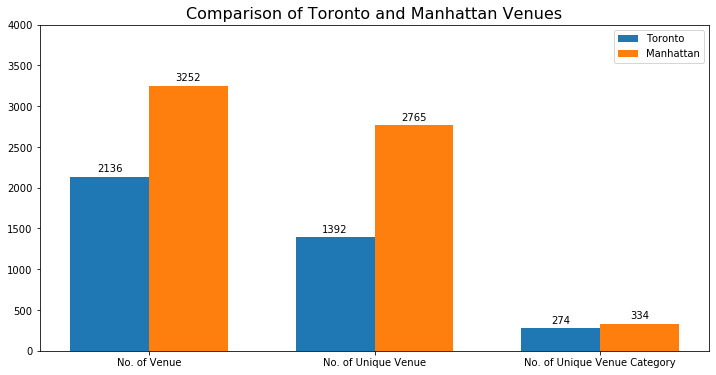

In [102]:
import matplotlib
import matplotlib.pyplot as plt

indx = np.arange(len(item_list))  # the label locations
score_label = np.arange(0, 4500, 500)
bar_width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
barToronto = ax.bar(indx - bar_width/2, toronto, bar_width, label='Toronto')
barManhattan = ax.bar(indx + bar_width/2, manhattan, bar_width, label='Manhattan')

# inserting x axis label
ax.set_xticks(indx)
ax.set_xticklabels(item_list)

# inserting y axis label
ax.set_yticks(score_label)
ax.set_yticklabels(score_label)

ax.legend()
ax.set_title("Comparison of Toronto and Manhattan Venues", fontsize=16)

def insert_data_labels(bars):
	for bar in bars:
		bar_height = bar.get_height()
		ax.annotate('{0:.0f}'.format(bar.get_height()),
			xy=(bar.get_x() + bar.get_width() / 2, bar_height),
			xytext=(0, 3),
			textcoords='offset points',
			ha='center',
			va='bottom'
		)

insert_data_labels(barToronto)
insert_data_labels(barManhattan)

#plt.xticks(rotation=90)

plt.show()

In [103]:
toronto_venue_cat.head(3)

,Venue Category,Toronto
0,Coffee Shop,186
1,Café,92
2,Restaurant,62


In [104]:
manhattan_venue_cat.head(10)

,Venue Category,Manhattan
0,Coffee Shop,138
1,Italian Restaurant,131
2,American Restaurant,79
3,Café,79
4,Bakery,77
5,Pizza Place,75
6,Park,70
7,Hotel,66
8,Bar,62
9,Cocktail Bar,58


In [105]:
venue_category_merged = pd.merge(manhattan_venue_cat, toronto_venue_cat, on ='Venue Category')

In [106]:
venue_category_merged.shape

(212, 3)

In [107]:
venue_category_merged.set_index('Venue Category', inplace = True)

In [108]:
venue_category_merged.rename(columns={'Neighborhood':'Manhattan', 'Frequency':'Toronto'},inplace=True)
venue_category_merged

,Manhattan,Toronto
Venue Category,,
Coffee Shop,138,186
Italian Restaurant,131,47
American Restaurant,79,19
Café,79,92
Bakery,77,49
Pizza Place,75,47
Park,70,55
Hotel,66,34
Bar,62,33


In [109]:
venue_category_merged_50 = venue_category_merged.head(50)

In [110]:
venue_category_merged_50

,Manhattan,Toronto
Venue Category,,
Coffee Shop,138,186
Italian Restaurant,131,47
American Restaurant,79,19
Café,79,92
Bakery,77,49
Pizza Place,75,47
Park,70,55
Hotel,66,34
Bar,62,33


In [111]:
venue_cat= venue_category_merged_50.index.to_list()
manhattan_venue = venue_category_merged_50['Manhattan'].to_list()
toronto_venue = venue_category_merged_50['Toronto'].to_list()

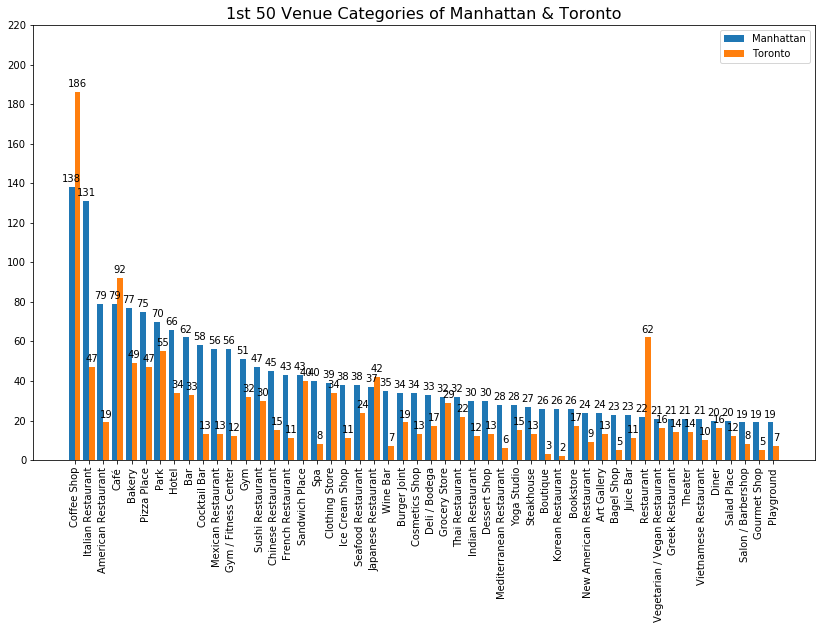

In [112]:
import matplotlib
import matplotlib.pyplot as plt


indx = np.arange(len(venue_cat))  # the label locations
score_label = np.arange(0, 225, 20)
bar_width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(14,8))
barManhattan = ax.bar(indx - bar_width/2, manhattan_venue, bar_width, label='Manhattan')
barToronto = ax.bar(indx + bar_width/2, toronto_venue, bar_width, label='Toronto')

# inserting x axis label
ax.set_xticks(indx)
ax.set_xticklabels(venue_cat)

# inserting y axis label
ax.set_yticks(score_label)
ax.set_yticklabels(score_label)
ax.set_title("1st 50 Venue Categories of Manhattan & Toronto", fontsize=16)
ax.legend()

def insert_data_labels(bars):
	for bar in bars:
		bar_height = bar.get_height()
		ax.annotate('{0:.0f}'.format(bar.get_height()),
			xy=(bar.get_x() + bar.get_width() / 2, bar_height),
			xytext=(0, 3),
			textcoords='offset points',
			ha='center',
			va='bottom'
		)

insert_data_labels(barManhattan)
insert_data_labels(barToronto)

plt.xticks(rotation=90)

plt.show()

#### Let's analyze the restaurants in Toronto and Manhattan 

In [113]:
print('Number of restaurants in Toronto : ',Number_of_Toronto_restaurants)
print('Number of restaurants in Manhattan : ',Number_of_Manhattan_restaurants)

Number of restaurants in Toronto :  481
Number of restaurants in Manhattan :  925


In [114]:
toronto_restaurants.head(3)

,Toronto
Venue Category,
Restaurant,62
Italian Restaurant,47
Japanese Restaurant,42


In [115]:
manhattan_restaurants.head(3)

,Manhattan
Venue Category,
Italian Restaurant,131
American Restaurant,79
Mexican Restaurant,56


In [116]:
restaurants_merged = pd.merge(toronto_restaurants, manhattan_restaurants, on ='Venue Category')
restaurants_merged.rename(columns={'Frequency':'Toronto', 'Neighborhood':'Manhattan'}, inplace=True)
restaurants_merged

,Toronto,Manhattan
Venue Category,,
Restaurant,62,22
Italian Restaurant,47,131
Japanese Restaurant,42,37
Sushi Restaurant,30,47
Fast Food Restaurant,29,5
Seafood Restaurant,24,38
Thai Restaurant,22,32
American Restaurant,19,79
Vegetarian / Vegan Restaurant,16,21


In [117]:
restaurant= restaurants_merged.index.to_list()
toronto_res = restaurants_merged['Toronto'].to_list()
manhattan_res = restaurants_merged['Manhattan'].to_list()

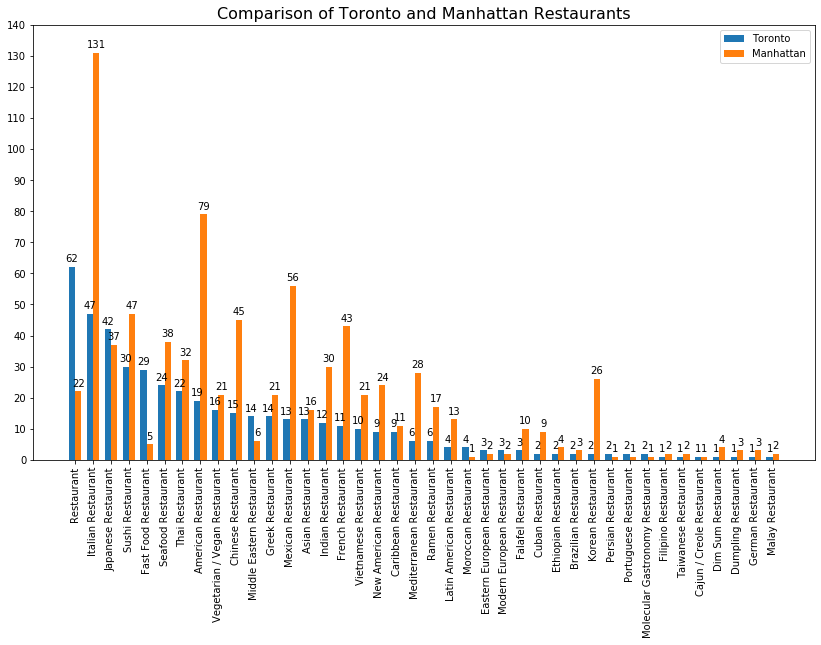

In [118]:
import matplotlib
import matplotlib.pyplot as plt


indx = np.arange(len(restaurant))  # the label locations
score_label = np.arange(0, 150, 10)
bar_width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14,8))
barToronto = ax.bar(indx - bar_width/2, toronto_res, bar_width, label='Toronto')
barManhattan = ax.bar(indx + bar_width/2, manhattan_res, bar_width, label='Manhattan')
# inserting x axis label
ax.set_xticks(indx)
ax.set_xticklabels(restaurant)
ax.set_title('Comparison of Toronto and Manhattan Restaurants', fontsize=16)
# inserting y axis label
ax.set_yticks(score_label)
ax.set_yticklabels(score_label)

ax.legend()

def insert_data_labels(bars):
	for bar in bars:
		bar_height = bar.get_height()
		ax.annotate('{0:.0f}'.format(bar.get_height()),
			xy=(bar.get_x() + bar.get_width() / 2, bar_height),
			xytext=(0, 3),
			textcoords='offset points',
			ha='center',
			va='bottom'
		)

insert_data_labels(barManhattan)
insert_data_labels(barToronto)

plt.xticks(rotation=90)

plt.show()

**Let's get the percentage of different restaurants in manhattan. Let's name it man_res_percentage.**

In [119]:
man_res_percentage = (100*manhattan_restaurants /898).round(2)
man_res_percentage

,Manhattan
Venue Category,
Italian Restaurant,14.59
American Restaurant,8.80
Mexican Restaurant,6.24
Sushi Restaurant,5.23
Chinese Restaurant,5.01
French Restaurant,4.79
Seafood Restaurant,4.23
Japanese Restaurant,4.12
Thai Restaurant,3.56


**Let's find the restaurants that are present in Manhattan but not found in Toronto**

In [120]:
to = toronto_restaurants.index.to_list()
ma = manhattan_restaurants.index.to_list()
manhattan_res_only = []
for m in ma:
    if m not in to:
        manhattan_res_only.append(m)
print('List of the reataurants only found in Manhattan: \n',manhattan_res_only)

List of the reataurants only found in Manhattan: 
 ['Spanish Restaurant', 'Tapas Restaurant', 'Turkish Restaurant', 'Peruvian Restaurant', 'Hawaiian Restaurant', 'Argentinian Restaurant', 'Shanghai Restaurant', 'Hotpot Restaurant', 'Australian Restaurant', 'African Restaurant', 'Southern / Soul Food Restaurant', 'Japanese Curry Restaurant', 'Israeli Restaurant', 'Jewish Restaurant', 'Lebanese Restaurant', 'Paella Restaurant', 'Udon Restaurant', 'Szechuan Restaurant', 'Kosher Restaurant', 'Austrian Restaurant', 'South Indian Restaurant', 'Kebab Restaurant', 'Caucasian Restaurant', 'Cantonese Restaurant', 'Arepa Restaurant', 'Afghan Restaurant', 'Venezuelan Restaurant', 'North Indian Restaurant', 'Empanada Restaurant', 'English Restaurant', 'Scandinavian Restaurant', 'Russian Restaurant', 'Himalayan Restaurant', 'Czech Restaurant', 'Swiss Restaurant']


**Let's find the restaurants that are present in Toronto but not found in Manhattan**

In [121]:
toronto_res_only = []
for t in to:
    if t not in ma:
        toronto_res_only.append(t)
print('List of the reataurants only found in Toronto: \n',toronto_res_only)

List of the reataurants only found in Toronto: 
 ['Comfort Food Restaurant', 'Gluten-free Restaurant', 'Belgian Restaurant', 'Colombian Restaurant', 'Tibetan Restaurant', 'Theme Restaurant', 'Hakka Restaurant', 'Doner Restaurant', 'Korean BBQ Restaurant']


In [122]:
print('Number of outstanding reataurants found only in manhattan are:{}'.format(len(manhattan_res_only)))
print('Number of outstanding reataurants found only in toronto are:{}'.format(len(toronto_res_only)))

Number of outstanding reataurants found only in manhattan are:35
Number of outstanding reataurants found only in toronto are:9


**Let's find the number of 1st most common venues of the five clusters of Toronto**

In [123]:
tc_1 = Toronto_Cluster_1['1st Most Common Venue'].value_counts().to_frame().reset_index()
tc_1

,index,1st Most Common Venue
0,Coffee Shop,21
1,Grocery Store,7
2,Café,6
3,Pizza Place,3
4,Gym,3
5,Furniture / Home Store,2
6,Indian Restaurant,2
7,Bar,2
8,Clothing Store,2
9,Restaurant,2


In [124]:
#Toronto_Cluster_2.shape
tc_2 =Toronto_Cluster_2['1st Most Common Venue'].value_counts().to_frame().reset_index()
tc_2

,index,1st Most Common Venue
0,Park,11
1,Food & Drink Shop,1
2,Bus Line,1
3,River,1
4,Intersection,1


In [125]:
#Toronto_Cluster_3.shape
tc_3 = Toronto_Cluster_3['1st Most Common Venue'].value_counts().to_frame().reset_index()
tc_3.head()

,index,1st Most Common Venue
0,Fast Food Restaurant,1


In [126]:
#Toronto_Cluster_4.shape
tc_4 = Toronto_Cluster_4['1st Most Common Venue'].value_counts().to_frame().reset_index()
tc_4

,index,1st Most Common Venue
0,Baseball Field,2


In [127]:
#Toronto_Cluster_5.shape
tc_5 = Toronto_Cluster_5['1st Most Common Venue'].value_counts().to_frame().reset_index()
tc_5

,index,1st Most Common Venue
0,Bakery,1
1,Smoke Shop,1


**Let's find the number of 1st most common venues of the five clusters of Manhattan**

In [128]:
#Manhattan_Cluster_1.shape
mc_1 = Manhattan_Cluster_1['1st Most Common Venue'].value_counts().to_frame().reset_index()
mc_1

,index,1st Most Common Venue
0,Italian Restaurant,8
1,Coffee Shop,3
2,Bar,2
3,Chinese Restaurant,2
4,Bakery,1
5,African Restaurant,1
6,American Restaurant,1
7,Mexican Restaurant,1
8,Clothing Store,1


In [129]:
#Manhattan_Cluster_2.shape
mc_2 = Manhattan_Cluster_2['1st Most Common Venue'].value_counts().to_frame().reset_index()
mc_2

,index,1st Most Common Venue
0,Coffee Shop,3
1,Italian Restaurant,2
2,Gym / Fitness Center,1
3,Exhibit,1
4,Korean Restaurant,1
5,Hotel,1


In [130]:
#Manhattan_Cluster_3.shape
mc_3 = Manhattan_Cluster_3['1st Most Common Venue'].value_counts().to_frame().reset_index()
mc_3

,index,1st Most Common Venue
0,Bar,1


In [131]:
mc_4 = Manhattan_Cluster_4['1st Most Common Venue'].value_counts().to_frame().reset_index()
mc_4

,index,1st Most Common Venue
0,Park,3
1,Mexican Restaurant,2
2,Pizza Place,1
3,Café,1
4,Coffee Shop,1
5,Plaza,1


In [132]:
mc_5 = Manhattan_Cluster_5['1st Most Common Venue'].value_counts().to_frame().reset_index()
mc_5

,index,1st Most Common Venue
0,Coffee Shop,1


In the analysis, we have devided the neighborhoods with five clusters. Then from each cluster, we find the largest number of the 1st most common venue.


#### The most frequent venues of all the Toronto clusters are as follows:

In [133]:
print('The most frequent of venue of 1st Most Common Venue of Toronto_Cluster_1 is: {}, {}'.format(tc_1.loc[0, 'index'],tc_1.loc[0, '1st Most Common Venue']))
print('The most frequent of venue of 1st Most Common Venue of Toronto_Cluster_2 is: {}, {}'.format(tc_2.loc[0, 'index'], tc_2.loc[0, '1st Most Common Venue']))
print('The most frequent of venue of 1st Most Common Venue of Toronto_Cluster_3 is: {}, {}'.format(tc_3.loc[0, 'index'],tc_3.loc[0, '1st Most Common Venue']))
print('The most frequent of venue of 1st Most Common Venue of Toronto_Cluster_4 is: {}, {}'.format(tc_4.loc[0, 'index'],tc_4.loc[0, '1st Most Common Venue']))
print('The most frequent of venue of 1st Most Common Venue of Toronto_Cluster_5 is: {}, {}'.format(tc_5.loc[0, 'index'],tc_5.loc[0, '1st Most Common Venue']))

The most frequent of venue of 1st Most Common Venue of Toronto_Cluster_1 is: Coffee Shop, 21
The most frequent of venue of 1st Most Common Venue of Toronto_Cluster_2 is: Park, 11
The most frequent of venue of 1st Most Common Venue of Toronto_Cluster_3 is: Fast Food Restaurant, 1
The most frequent of venue of 1st Most Common Venue of Toronto_Cluster_4 is: Baseball Field, 2
The most frequent of venue of 1st Most Common Venue of Toronto_Cluster_5 is: Bakery, 1


#### The most frequent venues of all the Manhattan clusters are as follows:

In [134]:
print('The most frequent of venue of 1st Most Common Venue of Manhattan_cluster_1 is: {}, {}'.format(mc_1.loc[0, 'index'], mc_1.loc[0, '1st Most Common Venue']))
print('The most frequent of venue of 1st Most Common Venue of Manhattan_cluster_2 is: {}, {}'.format(mc_2.loc[0, 'index'], mc_2.loc[0, '1st Most Common Venue']))
print('The most frequent of venue of 1st Most Common Venue of Manhattan_cluster_3 is: {}, {}'.format(mc_3.loc[0, 'index'], mc_3.loc[0, '1st Most Common Venue']))
print('The most frequent of venue of 1st Most Common Venue of Manhattan_cluster_4 is: {}, {}'.format(mc_4.loc[0, 'index'], mc_4.loc[0, '1st Most Common Venue']))
print('The most frequent of venue of 1st Most Common Venue of Manhattan_cluster_5 is: {}, {}'.format(mc_5.loc[0, 'index'], mc_5.loc[0, '1st Most Common Venue']))


The most frequent of venue of 1st Most Common Venue of Manhattan_cluster_1 is: Italian Restaurant, 8
The most frequent of venue of 1st Most Common Venue of Manhattan_cluster_2 is: Coffee Shop, 3
The most frequent of venue of 1st Most Common Venue of Manhattan_cluster_3 is: Bar, 1
The most frequent of venue of 1st Most Common Venue of Manhattan_cluster_4 is: Park, 3
The most frequent of venue of 1st Most Common Venue of Manhattan_cluster_5 is: Coffee Shop, 1


If we take a look at the above results, we see that both Toronto and Manhattan has similar characteristics. 

The following is the list of the most frequent venue of the Toronto clusters in descending order:

1. Park
2. Fast Food Restaurant
3. Pizza Place
4. Coffee Shop
5. Baseball Field

The following is the list of the most frequent venue of the Manhattan clusters in descending order:

1. Italian Restaurant
2. Coffee Shop
3. Park
4. Mexican Restaurant
5. Korean Restaurant

After analyzing the venue categories of the two cities (Toronto and Manhattan), we skim the most frequent number of venues available in both the cities.


### Results and Discussion
<a id="results"></a>

From the analysis and result section of the clusters of the two cities above, we can come up with the following conclusion:

* Both Toronto and Manhattan have similar category of venues 
* Three of the five clusters of  both Toronto and Manhattan have Park, Coffee Shop and Restaurant 
* Another common venue is Restaurant
* Toronto is more popular with Fast Food Restautrant
* Manhattan is more popular with Italian Restaurant



We find the following number of venues for both the cities:

* The total number of venues for Toronto : **2136**
* The total number of venues for Manhattan : **3252**
* The total number of unique venues for Toronto : **1392**
* The total number of unique venues for Manhattan : **2765**

From the analysis of the Restaurants of the two cities, we  find that Manhattan has almost twice the number of reataurants then Toronto following:

* Number of restaurants in Toronto :  **481**
* Number of restaurants in Manhattan :  **925**

Also there are some unique restaurants which are only found in either of the two cities. 

* Number of unique restaurants only in Toronto :  **9**
* Number of unique restaurants only in Manhattan :  **35**



Both Toronto and Manhattan have similar characteristics about the type of venues. Manhattan has higher number of venues, unique venues, unique venue categories and restaurants than city of Toronto. Also both cities offer some distinct venues and restaurants.

### Conclusion
<a id="conclusion"></a>

The objective of this project was to compare the city of Toronto and Manhattan of New York city based on their venues. I compared the number of venues, number of unique venues, number of unique venue categories. I also compared the restaurants of these two cities. The number and types of restaurants offered by the two cities are compared. Both cities have common and unique restaurants. I have used K-means clustering to cluster venue categories in both cities. 
This analysis will help the curious stakeholders to have a picture about venues in Toronto and Manhattan and help them make decisions.
